# Aim of this notebook

In [ ]:
# attempt to create cross encoder model and train it on russian texts to predict relevance of pair (question - answer)
# potentially it helps find more relevant text chunk in RAG
# resulting model is under cc-by-sa-4.0 because of xquad dataset

# Setting up...

In [30]:
%%capture
!pip install transformers sentencepiece

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [31]:
%%capture
!git lfs install
!git clone https://huggingface.co/cointegrated/rubert-tiny2

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [32]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from collections import OrderedDict
import gc
import pickle
from pathlib import Path
from dataclasses import dataclass
from typing import Any

import torch
from torch import nn
from torch.nn import functional as F

from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from numpy.lib.stride_tricks import sliding_window_view

In [33]:
os.listdir('./')
# ['LaBSE-en-ru', 'CrossEncoderModel', '.virtual_documents', 'df.pickle']

['.virtual_documents',
 'CrossEncoderModel',
 'rubert-tiny2',
 'LaBSE-en-ru',
 'df.pickle']

In [34]:
# for reproducability
seed = 42; random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

In [35]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_path = './CrossEncoderModel'  # best checkpoint is saving to disk

# Create Model class (Cross-Encoder neural net)

In [64]:
class Model(nn.Module):
    """
    labse - base bert-like model
    form labse i use pooler layer as intpu
    then classification head - binary classification to predict if this pair is TRUE question-answer
    """
    def __init__(self):
        super().__init__()
        self.labse  = AutoModel.from_pretrained('./LaBSE-en-ru')
        self.tokenizer = AutoTokenizer.from_pretrained('./LaBSE-en-ru', use_fast=True)
        n_dim = 768
        self.cls = nn.Sequential(OrderedDict(
                                              [
                                                ('dropout', torch.nn.Dropout(.0)),

                                                ('fc_1' , nn.Linear(n_dim, n_dim*2)),
                                                ('relu_1' , nn.GELU()),
                                                ('layernorm_1' , nn.LayerNorm(n_dim*2, eps=1e-12)),

                                                ('fc_2' , nn.Linear(n_dim*2, n_dim)),
                                                ('relu_2' , nn.GELU()),
                                                ('layernorm_2' , nn.LayerNorm(n_dim, eps=1e-12)),

                                                ('fc_3' , nn.Linear(n_dim, 2, bias=False)),
                                              ]
                                ))
    def forward(self, text):
        token = self.tokenizer(text, padding=True, truncation=True, return_tensors='pt').to(device)
        model_output = self.labse(**token)
        result = self.cls(model_output.pooler_output)
        return result

# Load datasets and store it to disk

In [ ]:
# dataset = load_dataset("sberquad")  # problems with downloading. Skip this dataset

In [8]:
dataset_1 = load_dataset("RussianNLP/russian_super_glue", name='danetqa')
df_1 = (
    pd.concat([dataset_1['train'].to_pandas(), dataset_1['validation'].to_pandas(), dataset_1['test'].to_pandas()])
    .iloc[:, :2]
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset russian_super_glue downloaded and prepared to /root/.cache/huggingface/datasets/RussianNLP___russian_super_glue/danetqa/0.0.1/d4a95758759a48b32e7a94a8ac7c67046c9111ef4724d7b6a34993cf57eb6048. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset_2 = load_dataset("RussianNLP/russian_super_glue", name='muserc')
df_2 = (
    pd.concat([dataset_2['train'].to_pandas(), dataset_2['validation'].to_pandas(), dataset_2['test'].to_pandas()])
    .loc[:, ['question', 'paragraph']]
    .set_axis(['question', 'passage'], axis=1)
)

In [ ]:
dataset_3 = load_dataset("xquad", 'xquad.ru')
df_3 = (
    dataset_3['validation'].to_pandas()
    .loc[:, ['question', 'context']]
    .set_axis(['question', 'passage'], axis=1)
)

In [9]:
df = (
    pd.concat([df_1])
    .dropna()
    .map(str)
    .drop_duplicates()
    .loc[lambda df: df['passage'].str.len() < 2000]  # remove very long str
)

In [11]:
df.shape

(3362, 2)

In [12]:
df.sample(5)

,question,passage
1116,Была ли рада знакомству анна сергеевна?,Анна Сергеевна шла на несколько шагов сзади и...
617,Была ли оккупация калинина выдумкой?,Оккупа́ция Кали́нина — временное занятие войск...
807,Болеют ли коровы энцефалитом?,Японский энцефалит — острое инфекционное забо...
524,Вреден ли фтор в зубной пасте?,Ополаскиватели для рта с фтором рекомендуются ...
196,Входит ли россия в европейский союз?,Ныне действующее Соглашение о партнёрстве и со...


In [13]:
with open('df.pickle', 'wb') as f:
    pickle.dump(df, f, protocol=pickle.HIGHEST_PROTOCOL)

In [124]:
df.head(10)

,question,passage
0,Когда был спущен на воду первый миноносец «Спо...,Зачислен в списки ВМФ СССР 19 августа 1952 год...
1,Как долго существовало британское телевизионно...,"Хрустальный лабиринт (""The Crystal Maze"") — бр..."
2,Когда родилась Князева Марина Леонидовна?,Князева Марина Леонидовна (род. 7 мая 1952 г.)...
3,Кто был главным художником мира Зен?,"В книге ""Half-Life 2: Raising the Bar"" художни..."
4,Как звали предполагаемого убийцу Джона Кеннеди?,В 1966 году окружной прокурор Нового Орлеана Д...
5,Как звали предполагаемого убийцу Джона Кеннеди?,"По версии Комитета, Освальд выпустил три пули...."
6,Как звали предполагаемого убийцу Джона Кеннеди?,"Мистер Икс признается, что он работал в отделе..."
7,Как звали предполагаемого убийцу Джона Кеннеди?,"22 ноября 1963 года, совершая предвыборную пое..."
8,Как звали предполагаемого убийцу Джона Кеннеди?,"Другим агентом Секретной службы, который предп..."
9,Как звали предполагаемого убийцу Джона Кеннеди?,"Позднее отмечалось, что ФБР с самого начала ра..."


# Load dataset from disk. Make train/test split

In [40]:
df_base = pd.read_pickle('/kaggle/input/qa-dataset/data_not_clean.pkl')
df = df_base[['clean_query', 'clean_text']]
df = df.rename(columns={"clean_query": "question", "clean_text": "passage"})
df.shape

(47009, 2)

In [46]:
df.sample(5)

,question,passage
34261,Какое имя было у Ивана Константиновича Айвазов...,Родился 31 мая 1810 года в городе Курске в сем...
12028,"Что означает слово ""ислам""?","Ислам ( — «покорность», «предание себя [Едином..."
9929,Когда появился первый фотоаппарат?,Появление первого фотоаппарата совпало с изобр...
5123,Где родился Михаил Михайлович Шульц?,"Михаил Михайлович Шульц (1 июля 1919, Петрогра..."
24864,Когда была канонизирована Жанна д’Арк?,Первые уроки религии Жанна получила от матери....


In [50]:
df.dtypes

question    object
passage     object
dtype: object

In [47]:
with open('df.pickle', 'rb') as f:
    df_old = pickle.load(f)

In [48]:
df_old.sample(5)

,question,passage
291,Была ли в ссср религия?,Религия в СССР — положение религии и конфессио...
716,Был ли поручик ржевский?,"Всякий видел голые члены мужчины, спереди и сз..."
865,Был ли веном в человеке пауке?,"Ве́ном — вымышленный персонаж, появляющийся в..."
1648,Могут ли неявное знание и опыт быть без труда ...,"Третья причина состоит в том, что концентрация..."
498,Был ли дефолт в россии?,Не путать с экономическим термином Дефолт.Экон...


In [49]:
df_old.dtypes

question    object
passage     object
dtype: object

In [ ]:
assert df.shape == (9550, 2)

In [41]:
df_train = df.sample(frac=.8).iloc[:, :2]
df_val = df.drop(df_train.index).iloc[:, :2]

In [37]:
df.shape

(3362, 2)

# Utility functions

In [42]:
def get_batch(df, n):
    """return batch witn n samples form given dataframe (test, val)
    each batch contains n samples. n/2 positive, and n/2 negative"""
    positive = df.sample(n=n//2).assign(targets = 1)
    negative = pd.concat([df[['question']].sample(n//2).reset_index(drop=True), 
                          df[['passage']].sample(n//2).reset_index(drop=True)],
                         axis=1,
                        ).assign(targets = 0)
    result = pd.concat([positive, negative])
    result = result.sample(frac=1)
    texts = result.iloc[:, [0, 1]].values.tolist()
    targets = result.iloc[:, 2].values.tolist()
    return texts, targets

In [17]:
def estimate_loss():
    """calculate train and val loss during the training. Val loss - main metric of quality of the checkpoint"""
    out = {}
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        accuracies = torch.zeros(eval_iters)
        for i in range(eval_iters):
            text, target = get_batch(df_train if split == 'train' else df_val, batch_size)
            loss, accuracy = calculate_loss(text, target)
            losses[i] = loss.item()
            accuracies[i] = accuracy.item()
        out[f'{split}_loss'] = losses.mean().item()
        out[f'{split}_accuracy'] = accuracies.mean().item()
    return out

In [18]:
def calculate_loss(text, target):
    """given batch and target labels returns two quality metrics: loss and accuracy"""
    logit = pac.model(text)
    target = torch.tensor(target, dtype=torch.long).to(device)
    loss = F.cross_entropy(logit, target)
    accuracy = sum(logit.to('cpu').argmax(1) == target.to('cpu')) / target.to('cpu').size(0)
    return loss, accuracy

In [19]:
def set_lr(i, optimizer):
    """set learning rate function. Used in training process. Given the training step number (i) and optimizer object set learning rate"""
    if i < iterations * 0.2:  # warmup stage
        lr = learning_rate * 1e-2
    elif i < iterations * 0.8:  # main training stage
        lr = learning_rate
    else:
        lr = learning_rate * 1e-1  # closing stage
    optimizer.param_groups[0]['lr'] = lr

In [20]:
def train_model(pac):
    """train model. Model is in the pac object
    model related info we get from pac object
    general info and functions - from global scope"""
    pac.model.train()
    for i in range(iterations):
        set_lr(i, pac.optimizer)
        text, target = get_batch(df_train, batch_size)
        loss, _ = calculate_loss(text, target)  # do not need accuracy return here
        pac.optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(pac.model.parameters(), max_norm = 1)
        pac.optimizer.step()
        if i % eval_interval == 0:
            pac.model.eval()
            losses = estimate_loss()
            print(f"step {i}: train loss {losses['train_loss']:.8f}, val loss {losses['val_loss']:.8f} ", end='')
            print(f"train accuracy {losses['train_accuracy']:.0%}, val accuracy {losses['val_accuracy']:.0%}")
            pac.train_loss_history.append(losses['train_loss'])
            pac.val_loss_history.append(losses['val_loss'])
            if losses['val_loss'] < pac.best_val_loss:
                print(f"            saving checkpoint with val loss {losses['val_loss']:.8f}")
                pac.best_val_loss = losses['val_loss']
                checkpoint = {  'model': pac.model.state_dict(),
                                'optimizer': pac.optimizer.state_dict(),
                                'best_val_loss': pac.best_val_loss,
                                'train_loss_history' : pac.train_loss_history,
                                'val_loss_history' : pac.val_loss_history,}
                torch.save(checkpoint, model_path)
            pac.model.train()
    pac.model.eval()

In [21]:
def load_model_pac(pac, **kwargs):
    """load model from disk. On disk we maintain only one model, without choice
    pac object will be filled with loaded model"""
    if Path(model_path).exists():
        state = torch.load(model_path, **kwargs)
        pac.model = Model().to(device)
        pac.model.load_state_dict(state['model'])
        pac.optimizer = torch.optim.AdamW(pac.model.parameters())
        pac.optimizer.load_state_dict(state['optimizer'])
        pac.best_val_loss = state['best_val_loss']
        pac.train_loss_history = state['train_loss_history']
        pac.val_loss_history = state['val_loss_history']
    else:
        print('WARNING!!! no file to get model. pac is returned without changes')

In [22]:
def plot_losses(pac):
    """plot smoothed losses for train and val
    x-axis is not very informative, due to smoothing (collapce several eval steps)
    so this plot is used only for basic visual understanding of trand in training"""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
    smooth = 8 if len(pac.train_loss_history) > 8 else 2
    ax[0].plot(sliding_window_view(pac.train_loss_history, window_shape = smooth).mean(1))
    ax[1].plot(sliding_window_view(pac.val_loss_history, window_shape = smooth).mean(1))
    ax[0].set_title('train_loss_history')
    ax[1].set_title('val_loss_history')
    fig.suptitle('plot losses')
    plt.show()

# ModelPackage class is designed for conveniency

In [23]:
@dataclass
class ModelPackage:
    """main object. contain all key data concerning the model. we create one instance only and work with it"""
    model : Any = None
    optimizer : Any = None
    best_val_loss : Any = None
    train_loss_history : Any =None
    val_loss_history : Any = None

# Create untrained model

In [65]:
base_model = Model().to(device)
torch.nn.init.zeros_(base_model.cls.fc_1.bias)
torch.nn.init.zeros_(base_model.cls.fc_2.bias)
base_optimizer = torch.optim.AdamW(base_model.parameters(), lr=5e-5)  # lr (learning rate) will be overriden by set_lr function every step of training
pac = ModelPackage(model=base_model, optimizer=base_optimizer, best_val_loss=1e+9, train_loss_history=[], val_loss_history=[])  # key object with model

# Load trained model

In [52]:
# used if we start with existing model on disk
# load_model_pac(pac)  # use if we save and load on the same device
load_model_pac(pac, map_location=torch.device('cpu')) # map_locations is needed if we train on gpu, save to disk. But after that switch to cpu device

# Stage 1. Train classification head only

In [66]:
learning_rate = 9e-5
batch_size = 8
iterations = 1000
eval_times = 25
eval_interval = iterations // eval_times
eval_iters = 25

In [67]:
for name, parameter in pac.model.named_parameters():
    if name.startswith('cls'):
        parameter.requires_grad = True
    else:
        parameter.requires_grad = False

In [68]:
%%time
train_model(pac)

step 0: train loss 0.73764318, val loss 0.72311676 train accuracy 51%, val accuracy 52%
            saving checkpoint with val loss 0.72311676
step 40: train loss 0.76253051, val loss 0.71379316 train accuracy 51%, val accuracy 56%
            saving checkpoint with val loss 0.71379316
step 80: train loss 0.79043961, val loss 0.74271685 train accuracy 43%, val accuracy 49%
step 120: train loss 0.71407092, val loss 0.72723395 train accuracy 54%, val accuracy 51%
step 160: train loss 0.71669179, val loss 0.76917160 train accuracy 52%, val accuracy 48%
step 200: train loss 0.74280238, val loss 0.69318771 train accuracy 51%, val accuracy 56%
            saving checkpoint with val loss 0.69318771
step 240: train loss 0.76871949, val loss 0.73465872 train accuracy 59%, val accuracy 57%
step 280: train loss 0.72449732, val loss 0.59139323 train accuracy 52%, val accuracy 67%
            saving checkpoint with val loss 0.59139323
step 320: train loss 0.69270051, val loss 0.68143761 train accur

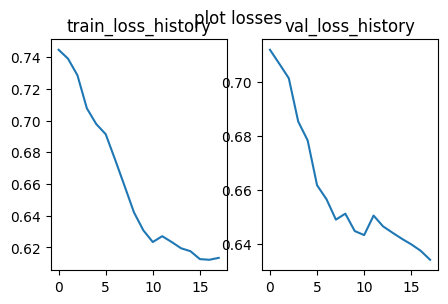

In [69]:
plot_losses(pac)

# Stage 2. Train entire model

In [70]:
learning_rate = 1e-5
batch_size = 8
iterations = 2000
eval_times = 50
eval_interval = iterations // eval_times
eval_iters = 25

In [71]:
load_model_pac(pac)  # load best checkpoing form Stage 1

In [72]:
for name, parameter in pac.model.named_parameters():
    parameter.requires_grad = True

In [73]:
%%time
train_model(pac)

step 0: train loss 0.64821726, val loss 0.60402650 train accuracy 60%, val accuracy 63%
step 40: train loss 0.56358117, val loss 0.56978899 train accuracy 70%, val accuracy 71%
            saving checkpoint with val loss 0.56978899
step 80: train loss 0.52668417, val loss 0.66612655 train accuracy 72%, val accuracy 62%
step 120: train loss 0.59369320, val loss 0.64963812 train accuracy 68%, val accuracy 63%
step 160: train loss 0.59953016, val loss 0.60010982 train accuracy 69%, val accuracy 64%
step 200: train loss 0.53227818, val loss 0.57118654 train accuracy 73%, val accuracy 71%
step 240: train loss 0.62408376, val loss 0.56874353 train accuracy 62%, val accuracy 70%
            saving checkpoint with val loss 0.56874353
step 280: train loss 0.54783744, val loss 0.57952100 train accuracy 77%, val accuracy 70%
step 320: train loss 0.58614975, val loss 0.60602736 train accuracy 64%, val accuracy 68%
step 360: train loss 0.55647379, val loss 0.58043236 train accuracy 75%, val accurac

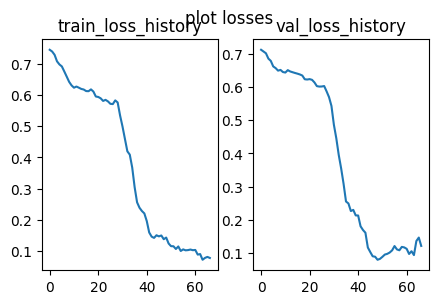

In [74]:
plot_losses(pac)

# Stage 3. Try regularization for better generalization

In [ ]:
learning_rate = 5e-6
batch_size = 8
iterations = 1000
eval_times = 100
eval_interval = iterations // eval_times
eval_iters = 25

In [ ]:
load_model_pac(pac)

In [ ]:
for name, parameter in pac.model.named_parameters():
    parameter.requires_grad = True

In [ ]:
pac.optimizer.param_groups[0]['weight_decay'] = 0.03
pac.model.cls[0].p = 0.1

In [ ]:
%%time
train_model(pac)

In [ ]:
plot_losses(pac)

# Try model on few examples

In [75]:
pac.model.eval();

In [ ]:
pac.model([
    ['где дают бананы?','фрукты можно купить везде, в т.ч. в магазине за углом, в т.ч. бананы']
])

# tensor([[-3.9197,  3.6654]], grad_fn=<MmBackward0>)

In [76]:
questions = ['где можно взять лодку на прокат?', 
             'где можно взять лодку на прокат?']
answers = ['взятие тракторов для пользования не предусмотрено', 
            'небольшой катер обычно берут в аренду у берега']
pac.model(list(zip(questions, answers))).argmax(1)

# tensor([0, 1])

tensor([1, 1], device='cuda:0')

In [77]:
questions = ['где можно взять лодку на прокат?', 
             'где можно взять лодку на прокат?']
answers = ['взятие тракторов для пользования не предусмотрено', 
            'небольшой катер обычно берут в аренду у берега']
pac.model(list(zip(questions, answers)))

# tensor([[-0.1967, -1.1687],
#         [-3.2954,  2.5626]], grad_fn=<MmBackward0>)

tensor([[-2.8620,  3.1068],
        [-3.2202,  3.5177]], device='cuda:0', grad_fn=<MmBackward0>)

In [93]:
def find_top_answers(question, df, pac, top_n=5):

    filtered_df = df[df['question'].str.contains(question, case=False)]
    
    pairs = list(zip([question] * len(filtered_df), filtered_df['passage'].tolist()))
    
    with torch.no_grad():
        scores = pac.model(pairs)

    relevancy_scores = torch.softmax(scores, dim=1)[:, 1].cpu().numpy()
    
    filtered_df = filtered_df.copy()
    filtered_df['relevancy'] = relevancy_scores
    top_answers = filtered_df.nlargest(top_n, 'relevancy')[['passage', 'relevancy']].values
    
    return top_answers.tolist()

In [122]:
# Задаем ваш вопрос
question = 'Как звали предполагаемого убийцу Джона Кеннеди?'

question = 'Кто убил Джона Кеннеди?'

# Получаем топ-5 ответов
top_k_answers = find_top_answers(question, df, pac, top_n=5)

# Выводим релевантные ответы
for i, (answer, score) in enumerate(top_k_answers, 1):
    print(f"{i}. Ответ: {answer} (релевантность: {score:.4f})")


1. Ответ: Убийство 35-го президента США Джона Кеннеди было совершено в пятницу 22 ноября 1963 года в Далласе (штат Техас) в 12:30 по местному времени. Кеннеди был смертельно ранен выстрелом из винтовки, когда он вместе со своей женой Жаклин ехал в президентском кортеже по Элм-Стрит. (релевантность: 0.9998)
2. Ответ: Впереди процессии шли вдова Джона Кеннеди — Жаклин (умерла в 1994 году) с детьми Джоном (погиб в авиакатастрофе летом 1999 года) и Кэролайн. С ними шли братья убитого президента — Роберт (убит в июне 1968 года в Лос-Анджелесе после победы на президентских праймериз в Калифорнии) и Эдвард (умер в августе 2009 года). (релевантность: 0.9997)
3. Ответ: 22 ноября 1963 года, совершая предвыборную поездку в Даллас, штат Техас, Джон Ф. Кеннеди был смертельно ранен из снайперской винтовки в открытом лимузине на одной из центральных улиц города. Президент был незамедлительно доставлен в госпиталь «», где после безуспешных попыток реанимации скончался около 13:00 по местному времени. 

In [120]:
df[df['question'].str.contains("Кто убил Джона Кеннеди?")]

,question,passage
281,Кто убил Джона Кеннеди?,"22 ноября 1963 года, совершая предвыборную пое..."
282,Кто убил Джона Кеннеди?,В 2008 году написал книгу об убийстве Джона Ке...
283,Кто убил Джона Кеннеди?,"Другим агентом Секретной службы, который предп..."
284,Кто убил Джона Кеннеди?,"Как установила комиссия Уоррена, Освальд остав..."
285,Кто убил Джона Кеннеди?,Убийство в течение десяти месяцев расследовала...
14287,Кто убил Джона Кеннеди?,Джон Кеннеди был убит 22 ноября 1963 года в го...
14288,Кто убил Джона Кеннеди?,"За три дня до трёхлетия Джона, 22 ноября 1963 ..."
14289,Кто убил Джона Кеннеди?,Джон Кеннеди был убит 22 ноября 1963 года. Жен...
14290,Кто убил Джона Кеннеди?,Убийство 35-го президента США Джона Кеннеди бы...
14291,Кто убил Джона Кеннеди?,Впереди процессии шли вдова Джона Кеннеди — Жа...


In [98]:
def find_most_similar_answers(question, df, pac, top_n=5, similar_n=10):

    question_pairs = list(zip([question] * len(df), df['question'].tolist()))
    
    with torch.no_grad():
        similarity_scores = pac.model(question_pairs)  # Получаем логиты от модели
    
    similarity_probs = torch.softmax(similarity_scores, dim=1)[:, 1].cpu().numpy()
    
    df = df.copy()
    df['similarity'] = similarity_probs
    filtered_df = df.nlargest(similar_n, 'similarity')
    
    pairs = list(zip([question] * len(filtered_df), filtered_df['passage'].tolist()))
    
    with torch.no_grad():
        relevancy_scores = pac.model(pairs)
    
    relevancy_probs = torch.softmax(relevancy_scores, dim=1)[:, 1].cpu().numpy()
    
    filtered_df['relevancy'] = relevancy_probs
    top_answers = filtered_df.nlargest(top_n, 'relevancy')[['passage', 'relevancy']].values
    
    return top_answers.tolist()

In [115]:
def find_most_similar_answers(question, df, pac, top_n=5, similar_n=10):

    question_pairs = list(zip([question] * len(df), df['question'].tolist()))
    
    with torch.no_grad():
        similarity_scores = pac.model(question_pairs)  # Получаем логиты от модели
    
    # Преобразуем логиты в вероятности для похожести
    similarity_probs = torch.softmax(similarity_scores, dim=1)[:, 1].cpu().numpy()
    
    # Добавляем похожесть в DataFrame и выбираем top similar_n вопросов
    df = df.copy()
    df['similarity'] = similarity_probs
    filtered_df = df.nlargest(similar_n, 'similarity')
    
    # Шаг 2: Оцениваем релевантность для выбранных строк с помощью модели
    pairs = list(zip([question] * len(filtered_df), filtered_df['passage'].tolist()))
    
    with torch.no_grad():
        relevancy_scores = pac.model(pairs)
    
    # Вероятности для класса "релевантно" из логитов
    relevancy_probs = torch.softmax(relevancy_scores, dim=1)[:, 1].cpu().numpy()
    
    # Добавляем релевантность и выбираем топ-N релевантных ответов
    filtered_df['relevancy'] = relevancy_probs
    top_answers = filtered_df.nlargest(top_n, 'relevancy')[['passage', 'relevancy']].values
    
    return top_answers.tolist()

In [97]:
def custom_metric(df_sorted):
    # n - общее количество ответов, k - количество правильных ответов
    n = len(df_sorted)
    k = df_sorted['label'].sum()
    if k == 0:
        return 1
    # Количество позиций для оценки
    top_k = max(3, int(k))
    
    # Отбираем первые top_k ответов после ранжирования
    top_k_answers = df_sorted.iloc[:top_k]
    
    # Считаем количество правильных ответов среди первых top_k
    correct_in_top_k = top_k_answers['label'].sum()
    
    # Рассчитываем процент правильных ответов среди первых top_k
    score = correct_in_top_k / k
    
    return score


In [ ]:
def metric_with_weight(df_sorted):
    n = len(df_sorted)
    k = df_sorted['label'].sum()

    if k == 0:
        return 1
    
    # Количество позиций для оценки
    top_k = max(3, int(k))

    # Отбираем первые top_k ответов после ранжирования
    top_k_answers = df_sorted.iloc[:top_k]
    
    # Считаем количество правильных ответов среди первых top_k
    correct_in_top_k = top_k_answers['label'].sum()

    # Рассчитываем процент правильных ответов среди первых top_k
    base_score = correct_in_top_k / k

    # Уверенность модели - добавляем веса на основе отклонения similarity от среднего
    avg_similarity = df_sorted['similarity'].mean()
    similarity_deviation = abs(df_sorted['similarity'] - avg_similarity)

    # Присваиваем вес каждому ответу: чем больше отклонение от среднего, тем больше вес
    weights = 1 + similarity_deviation / avg_similarity

    # Применяем веса к правильным ответам в первых top_k позициях
    weighted_correct_in_top_k = (top_k_answers['label'] * weights[:top_k]).sum()

    # Рассчитываем итоговый score с учетом весов
    weighted_score = weighted_correct_in_top_k / k

    return weighted_score


# Losses history by train stages

In [ ]:
# STAGE 1

# step 0: train loss 0.79412353, val loss 0.84221059 train accuracy 49%, val accuracy 48%
#             saving checkpoint with val loss 0.84221059
# step 40: train loss 0.72924376, val loss 0.73115647 train accuracy 51%, val accuracy 54%
#             saving checkpoint with val loss 0.73115647
# step 80: train loss 0.73981124, val loss 0.75152588 train accuracy 49%, val accuracy 47%
# step 120: train loss 0.72771335, val loss 0.74807602 train accuracy 51%, val accuracy 47%
# step 160: train loss 0.77939749, val loss 0.72617233 train accuracy 47%, val accuracy 49%
#             saving checkpoint with val loss 0.72617233
# step 200: train loss 0.74007195, val loss 0.70950353 train accuracy 54%, val accuracy 57%
#             saving checkpoint with val loss 0.70950353
# step 240: train loss 0.68401343, val loss 0.69303590 train accuracy 61%, val accuracy 53%
#             saving checkpoint with val loss 0.69303590
# step 280: train loss 0.67698979, val loss 0.69532287 train accuracy 56%, val accuracy 54%
# step 320: train loss 0.72850263, val loss 0.67263514 train accuracy 56%, val accuracy 56%
#             saving checkpoint with val loss 0.67263514
# step 360: train loss 0.69255590, val loss 0.72146660 train accuracy 59%, val accuracy 55%
# step 400: train loss 0.68619293, val loss 0.67486024 train accuracy 55%, val accuracy 61%
# step 440: train loss 0.65868139, val loss 0.66514850 train accuracy 57%, val accuracy 56%
#             saving checkpoint with val loss 0.66514850
# step 480: train loss 0.67908025, val loss 0.66647476 train accuracy 54%, val accuracy 60%
# step 520: train loss 0.66232920, val loss 0.65966827 train accuracy 59%, val accuracy 63%
#             saving checkpoint with val loss 0.65966827
# step 560: train loss 0.67822176, val loss 0.63167799 train accuracy 57%, val accuracy 62%
#             saving checkpoint with val loss 0.63167799
# step 600: train loss 0.69677591, val loss 0.66195786 train accuracy 61%, val accuracy 62%
# step 640: train loss 0.61692619, val loss 0.66163236 train accuracy 63%, val accuracy 62%
# step 680: train loss 0.62694627, val loss 0.64016610 train accuracy 65%, val accuracy 63%
# step 720: train loss 0.63997412, val loss 0.67900556 train accuracy 62%, val accuracy 55%
# step 760: train loss 0.65030175, val loss 0.68291694 train accuracy 61%, val accuracy 56%
# step 800: train loss 0.63057101, val loss 0.66442609 train accuracy 62%, val accuracy 57%
# step 840: train loss 0.68886626, val loss 0.68393791 train accuracy 54%, val accuracy 56%
# step 880: train loss 0.63452864, val loss 0.65890557 train accuracy 63%, val accuracy 61%
# step 920: train loss 0.64404315, val loss 0.65959030 train accuracy 61%, val accuracy 62%
# step 960: train loss 0.62983859, val loss 0.66499579 train accuracy 59%, val accuracy 60%
# CPU times: user 9min 28s, sys: 7.72 s, total: 9min 36s
# Wall time: 9min 16s

In [ ]:
# STAGE 2

# step 0: train loss 0.64807409, val loss 0.65243322 train accuracy 60%, val accuracy 58%
# step 40: train loss 0.62582612, val loss 0.68216646 train accuracy 62%, val accuracy 57%
# step 80: train loss 0.61494470, val loss 0.67762214 train accuracy 66%, val accuracy 55%
# step 120: train loss 0.64627242, val loss 0.65831965 train accuracy 61%, val accuracy 65%
# step 160: train loss 0.65480179, val loss 0.67438096 train accuracy 57%, val accuracy 59%
# step 200: train loss 0.66556144, val loss 0.65748858 train accuracy 58%, val accuracy 57%
# step 240: train loss 0.66550153, val loss 0.61176062 train accuracy 61%, val accuracy 65%
#             saving checkpoint with val loss 0.61176062
# step 280: train loss 0.66109121, val loss 0.67207110 train accuracy 56%, val accuracy 61%
# step 320: train loss 0.63779736, val loss 0.63213521 train accuracy 64%, val accuracy 62%
# step 360: train loss 0.65744269, val loss 0.64948457 train accuracy 62%, val accuracy 62%
# step 400: train loss 0.65619385, val loss 0.66104645 train accuracy 63%, val accuracy 61%
# step 440: train loss 0.59282470, val loss 0.60493809 train accuracy 68%, val accuracy 64%
#             saving checkpoint with val loss 0.60493809
# step 480: train loss 0.41255382, val loss 0.50889319 train accuracy 83%, val accuracy 78%
#             saving checkpoint with val loss 0.50889319
# step 520: train loss 0.19893558, val loss 0.33600381 train accuracy 92%, val accuracy 86%
#             saving checkpoint with val loss 0.33600381
# step 560: train loss 0.08319058, val loss 0.14183240 train accuracy 97%, val accuracy 95%
#             saving checkpoint with val loss 0.14183240
# step 600: train loss 0.00666719, val loss 0.17655067 train accuracy 100%, val accuracy 96%
# step 640: train loss 0.29461211, val loss 0.14158271 train accuracy 94%, val accuracy 96%
#             saving checkpoint with val loss 0.14158271
# step 680: train loss 0.06479676, val loss 0.20410343 train accuracy 99%, val accuracy 97%
# step 720: train loss 0.07892250, val loss 0.04432739 train accuracy 99%, val accuracy 100%
#             saving checkpoint with val loss 0.04432739
# step 760: train loss 0.12520830, val loss 0.10904044 train accuracy 98%, val accuracy 99%
# step 800: train loss 0.06092861, val loss 0.10705815 train accuracy 99%, val accuracy 98%
# step 840: train loss 0.02133765, val loss 0.11841661 train accuracy 100%, val accuracy 99%
# step 880: train loss 0.06895632, val loss 0.08352751 train accuracy 99%, val accuracy 99%
# step 920: train loss 0.08975571, val loss 0.17263176 train accuracy 99%, val accuracy 97%
# step 960: train loss 0.02646931, val loss 0.10187074 train accuracy 100%, val accuracy 99%
# step 1000: train loss 0.09389298, val loss 0.17538077 train accuracy 98%, val accuracy 97%
# step 1040: train loss 0.01161752, val loss 0.00258194 train accuracy 100%, val accuracy 100%
#             saving checkpoint with val loss 0.00258194
# step 1080: train loss 0.03129374, val loss 0.21214806 train accuracy 100%, val accuracy 96%
# step 1120: train loss 0.00586576, val loss 0.25093287 train accuracy 100%, val accuracy 97%
# step 1160: train loss 0.05082968, val loss 0.12571415 train accuracy 99%, val accuracy 98%
# step 1200: train loss 0.11010478, val loss 0.15339094 train accuracy 99%, val accuracy 98%
# step 1240: train loss 0.11880517, val loss 0.16282004 train accuracy 99%, val accuracy 98%
# step 1280: train loss 0.03201985, val loss 0.08177342 train accuracy 99%, val accuracy 99%
# step 1320: train loss 0.10509382, val loss 0.10571041 train accuracy 98%, val accuracy 98%
# step 1360: train loss 0.14815529, val loss 0.02899079 train accuracy 98%, val accuracy 100%
# step 1400: train loss 0.07860721, val loss 0.07924865 train accuracy 99%, val accuracy 98%
# step 1440: train loss 0.06954878, val loss 0.06195263 train accuracy 99%, val accuracy 99%
# step 1480: train loss 0.05324212, val loss 0.08504837 train accuracy 99%, val accuracy 99%
# step 1520: train loss 0.07825479, val loss 0.01499614 train accuracy 99%, val accuracy 100%
# step 1560: train loss 0.04293070, val loss 0.01900088 train accuracy 99%, val accuracy 100%
# step 1600: train loss 0.07113445, val loss 0.11955570 train accuracy 99%, val accuracy 98%
# step 1640: train loss 0.04255194, val loss 0.08636519 train accuracy 99%, val accuracy 99%
# step 1680: train loss 0.00033567, val loss 0.08952259 train accuracy 100%, val accuracy 98%
# step 1720: train loss 0.03199779, val loss 0.15928526 train accuracy 100%, val accuracy 98%
# step 1760: train loss 0.02553761, val loss 0.00028506 train accuracy 99%, val accuracy 100%
#             saving checkpoint with val loss 0.00028506
# step 1800: train loss 0.05970788, val loss 0.12594384 train accuracy 99%, val accuracy 98%
# step 1840: train loss 0.01171125, val loss 0.04804644 train accuracy 100%, val accuracy 99%
# step 1880: train loss 0.00428159, val loss 0.19274506 train accuracy 100%, val accuracy 97%
# step 1920: train loss 0.02928949, val loss 0.10581044 train accuracy 100%, val accuracy 99%
# step 1960: train loss 0.03604861, val loss 0.04417474 train accuracy 99%, val accuracy 100%
# CPU times: user 33min 13s, sys: 22.7 s, total: 33min 35s
# Wall time: 32min 57s

In [ ]:
# STAGE 3

# step 0: train loss 0.03313344, val loss 0.15841350 train accuracy 100%, val accuracy 97%
# step 10: train loss 0.07822359, val loss 0.03731958 train accuracy 99%, val accuracy 100%
# step 20: train loss 0.03944667, val loss 0.03441509 train accuracy 99%, val accuracy 100%
# step 30: train loss 0.06485459, val loss 0.00069498 train accuracy 99%, val accuracy 100%
# step 40: train loss 0.10936035, val loss 0.11608574 train accuracy 98%, val accuracy 98%
# step 50: train loss 0.07635579, val loss 0.03216156 train accuracy 98%, val accuracy 100%
# step 60: train loss 0.02852786, val loss 0.11391333 train accuracy 100%, val accuracy 99%
# step 70: train loss 0.01793208, val loss 0.04217679 train accuracy 100%, val accuracy 99%
# step 80: train loss 0.05543724, val loss 0.04691040 train accuracy 99%, val accuracy 100%
# step 90: train loss 0.03173131, val loss 0.06639267 train accuracy 100%, val accuracy 99%
# step 100: train loss 0.02930402, val loss 0.08731505 train accuracy 100%, val accuracy 99%
# step 110: train loss 0.04601730, val loss 0.04480142 train accuracy 100%, val accuracy 99%
# step 120: train loss 0.06164711, val loss 0.07576244 train accuracy 99%, val accuracy 99%
# step 130: train loss 0.06064750, val loss 0.07630124 train accuracy 99%, val accuracy 99%
# step 140: train loss 0.03134467, val loss 0.06461988 train accuracy 100%, val accuracy 99%
# step 150: train loss 0.06227459, val loss 0.09088564 train accuracy 99%, val accuracy 98%
# step 160: train loss 0.08173700, val loss 0.05954036 train accuracy 99%, val accuracy 99%
# step 170: train loss 0.02468165, val loss 0.09435227 train accuracy 100%, val accuracy 99%
# step 180: train loss 0.01675455, val loss 0.03646864 train accuracy 100%, val accuracy 100%
# step 190: train loss 0.04307995, val loss 0.03101605 train accuracy 100%, val accuracy 100%
# step 200: train loss 0.00204842, val loss 0.10357299 train accuracy 100%, val accuracy 99%
# step 210: train loss 0.00061649, val loss 0.11264284 train accuracy 100%, val accuracy 99%
# step 220: train loss 0.03433675, val loss 0.04571404 train accuracy 100%, val accuracy 100%
# step 230: train loss 0.00972372, val loss 0.05984310 train accuracy 100%, val accuracy 99%
# step 240: train loss 0.02974055, val loss 0.05615148 train accuracy 99%, val accuracy 98%
# step 250: train loss 0.04699779, val loss 0.04247630 train accuracy 99%, val accuracy 100%
# step 260: train loss 0.04840694, val loss 0.09070937 train accuracy 99%, val accuracy 98%
# step 270: train loss 0.03889289, val loss 0.07267131 train accuracy 99%, val accuracy 99%
# step 280: train loss 0.00046847, val loss 0.14858441 train accuracy 100%, val accuracy 98%
# step 290: train loss 0.03440094, val loss 0.06505390 train accuracy 100%, val accuracy 99%
# step 300: train loss 0.08033683, val loss 0.05670303 train accuracy 99%, val accuracy 99%
# step 310: train loss 0.01275486, val loss 0.11045735 train accuracy 100%, val accuracy 98%
# step 320: train loss 0.14007929, val loss 0.06832070 train accuracy 98%, val accuracy 98%
# step 330: train loss 0.04115894, val loss 0.27593118 train accuracy 100%, val accuracy 96%
# step 340: train loss 0.06787842, val loss 0.16488355 train accuracy 99%, val accuracy 98%
# step 350: train loss 0.00376335, val loss 0.10732165 train accuracy 100%, val accuracy 98%
# step 360: train loss 0.04219292, val loss 0.13794678 train accuracy 100%, val accuracy 98%
# step 370: train loss 0.01794956, val loss 0.08549476 train accuracy 100%, val accuracy 99%
# step 380: train loss 0.00664156, val loss 0.06113205 train accuracy 100%, val accuracy 99%
# step 390: train loss 0.02952246, val loss 0.08019330 train accuracy 100%, val accuracy 98%
# step 400: train loss 0.02686654, val loss 0.06796777 train accuracy 100%, val accuracy 99%
# step 410: train loss 0.03506672, val loss 0.00061607 train accuracy 100%, val accuracy 100%
# step 420: train loss 0.00040313, val loss 0.09697559 train accuracy 100%, val accuracy 99%
# step 430: train loss 0.08684285, val loss 0.03400612 train accuracy 99%, val accuracy 100%
# step 440: train loss 0.10586292, val loss 0.00043009 train accuracy 99%, val accuracy 100%
# step 450: train loss 0.06953645, val loss 0.00028551 train accuracy 99%, val accuracy 100%
# step 460: train loss 0.10030007, val loss 0.12080386 train accuracy 99%, val accuracy 98%
# step 470: train loss 0.03866797, val loss 0.03003245 train accuracy 100%, val accuracy 100%
# step 480: train loss 0.04012363, val loss 0.09783294 train accuracy 99%, val accuracy 99%
# step 490: train loss 0.08097973, val loss 0.07225196 train accuracy 99%, val accuracy 99%
# step 500: train loss 0.05727426, val loss 0.11812568 train accuracy 99%, val accuracy 99%
# step 510: train loss 0.13891590, val loss 0.05494320 train accuracy 98%, val accuracy 99%
# step 520: train loss 0.03785620, val loss 0.13995415 train accuracy 99%, val accuracy 98%
# step 530: train loss 0.02305291, val loss 0.13730730 train accuracy 100%, val accuracy 98%
# step 540: train loss 0.10677733, val loss 0.10677902 train accuracy 98%, val accuracy 98%
# step 550: train loss 0.04948232, val loss 0.05700847 train accuracy 99%, val accuracy 99%
# step 560: train loss 0.03162992, val loss 0.16887741 train accuracy 100%, val accuracy 97%
# step 570: train loss 0.06787229, val loss 0.12693454 train accuracy 99%, val accuracy 98%
# step 580: train loss 0.03640221, val loss 0.13603944 train accuracy 99%, val accuracy 96%
# step 590: train loss 0.00029937, val loss 0.04636549 train accuracy 100%, val accuracy 99%
# step 600: train loss 0.11262832, val loss 0.06595978 train accuracy 98%, val accuracy 99%
# step 610: train loss 0.04218953, val loss 0.05144732 train accuracy 100%, val accuracy 99%
# step 620: train loss 0.03137173, val loss 0.03652409 train accuracy 100%, val accuracy 99%
# step 630: train loss 0.03049612, val loss 0.11578881 train accuracy 99%, val accuracy 99%
# step 640: train loss 0.00083526, val loss 0.08672986 train accuracy 100%, val accuracy 99%
# step 650: train loss 0.00070211, val loss 0.07699781 train accuracy 100%, val accuracy 99%
# step 660: train loss 0.06486022, val loss 0.10134209 train accuracy 99%, val accuracy 99%
# step 670: train loss 0.01440498, val loss 0.07668767 train accuracy 100%, val accuracy 98%
# step 680: train loss 0.06244498, val loss 0.15444818 train accuracy 99%, val accuracy 98%
# step 690: train loss 0.04521095, val loss 0.01206185 train accuracy 99%, val accuracy 100%
# step 700: train loss 0.03260354, val loss 0.09581573 train accuracy 100%, val accuracy 98%
# step 710: train loss 0.00028261, val loss 0.00437240 train accuracy 100%, val accuracy 100%
# step 720: train loss 0.00249931, val loss 0.00147725 train accuracy 100%, val accuracy 100%
# step 730: train loss 0.08718506, val loss 0.08158974 train accuracy 99%, val accuracy 99%
# step 740: train loss 0.01769382, val loss 0.10598854 train accuracy 100%, val accuracy 98%
# step 750: train loss 0.04374614, val loss 0.12430875 train accuracy 99%, val accuracy 99%
# step 760: train loss 0.09916076, val loss 0.03355389 train accuracy 98%, val accuracy 99%
# step 770: train loss 0.04037651, val loss 0.03937405 train accuracy 100%, val accuracy 100%
# step 780: train loss 0.00090255, val loss 0.14745142 train accuracy 100%, val accuracy 98%
# step 790: train loss 0.03804865, val loss 0.21588147 train accuracy 99%, val accuracy 97%
# step 800: train loss 0.04994744, val loss 0.08471793 train accuracy 99%, val accuracy 98%
# step 810: train loss 0.00892081, val loss 0.00422161 train accuracy 100%, val accuracy 100%
# step 820: train loss 0.00035513, val loss 0.04125996 train accuracy 100%, val accuracy 100%
# step 830: train loss 0.00025660, val loss 0.00486484 train accuracy 100%, val accuracy 100%
# step 840: train loss 0.01579638, val loss 0.10276839 train accuracy 100%, val accuracy 99%
# step 850: train loss 0.00026390, val loss 0.10335478 train accuracy 100%, val accuracy 99%
# step 860: train loss 0.08954148, val loss 0.00066520 train accuracy 99%, val accuracy 100%
# step 870: train loss 0.09544469, val loss 0.17500812 train accuracy 98%, val accuracy 98%
# step 880: train loss 0.03360385, val loss 0.09608832 train accuracy 100%, val accuracy 98%
# step 890: train loss 0.03605228, val loss 0.11177836 train accuracy 99%, val accuracy 98%
# step 900: train loss 0.08734855, val loss 0.14916398 train accuracy 98%, val accuracy 98%
# step 910: train loss 0.09945005, val loss 0.03843357 train accuracy 98%, val accuracy 100%
# step 920: train loss 0.03492024, val loss 0.05599483 train accuracy 100%, val accuracy 99%
# step 930: train loss 0.06949103, val loss 0.17588110 train accuracy 99%, val accuracy 97%
# step 940: train loss 0.00150970, val loss 0.07214484 train accuracy 100%, val accuracy 99%
# step 950: train loss 0.08483455, val loss 0.00019430 train accuracy 99%, val accuracy 100%
#             saving checkpoint with val loss 0.00019430
# step 960: train loss 0.02069252, val loss 0.13198288 train accuracy 100%, val accuracy 98%
# step 970: train loss 0.00121521, val loss 0.03663138 train accuracy 100%, val accuracy 100%
# step 980: train loss 0.00383111, val loss 0.09045857 train accuracy 100%, val accuracy 98%
# step 990: train loss 0.00019747, val loss 0.03986220 train accuracy 100%, val accuracy 100%
# CPU times: user 32min 9s, sys: 6.12 s, total: 32min 16s
# Wall time: 31min 17s

# Technical details of the model, attempt of analysis: grad to data ratio (just for general sense)

In [ ]:
print(
    f'{sum(p.numel() for p in pac.model.parameters()):_.0f}'
)

In [ ]:
size_model = 0
for param in pac.model.parameters():
    if param.data.is_floating_point():
        size_model += param.numel() * torch.finfo(param.data.dtype).bits
    else:
        size_model += param.numel() * torch.iinfo(param.data.dtype).bits
print(f"model size: {size_model} / bit | {size_model / 8e6:.2f} / MB")

In [ ]:
for name, parameter in pac.model.named_parameters():
    print(f'{name}'.ljust(60), f'{parameter.numel():_}'.ljust(20), f'{tuple(parameter.shape)}'.ljust(20), 
          f' {parameter.device} ', f' {parameter.dtype} ', f' {parameter.requires_grad} ')

In [ ]:
# https://discuss.pytorch.org/t/no-gradient-on-cuda/144807/3
pac.model.train()
text, target = get_batch(df_train, 2)
loss, _ = calculate_loss(text, target)
pac.optimizer.zero_grad(set_to_none=True)
loss.backward()
# torch.nn.utils.clip_grad_norm_(pac.model.parameters(), max_norm = 1)

In [ ]:
for name, parameter in pac.model.named_parameters():
    if not name.startswith('cls'): continue
#     if parameter.numel() < 1_000_000:  continue
    try:
#         print(f'{name}, {parameter.numel()}, std'.ljust(100),   abs(parameter.grad.std().item() / parameter.std().item()))
        print(f'{name}, {parameter.numel():_}, mean'.ljust(100),  abs(parameter.grad.mean().item() / parameter.mean().item()))
#         print(f'{name}, {parameter.numel():_}, mean'.ljust(100), f'{parameter.mean().item():.2f}'.ljust(10), f'{parameter.std().item():.2f}'.ljust(10))
    except ZeroDivisionError:
        print(f'{name}'.ljust(100), '!!! ERROR')
    except AttributeError:
        print(f'{name}'.ljust(100), 'no grad')

# Push to huggingface hub (not done)

In [ ]:
# examples code pushing to huggingface hub:

# https://colab.research.google.com/drive/1mSWfIQ6PIlteLVZ9DKKpcorycgLIKZLf?usp=sharing#scrollTo=1WjOABb5EVce
# https://colab.research.google.com/gist/avidale/7bc6350f26196918bf339c01261f5c60/rubert-tiny.ipynb
# https://huggingface.co/docs/transformers/v4.15.0/model_sharing

# Miscellaneous

In [ ]:
# free, total = torch.cuda.mem_get_info()
# used = total - free
# print(f'{used:_}')

In [ ]:
# text, target, loss, _, losses = [None] * 5
# torch.cuda.empty_cache(); gc.collect()
# text, target, loss, accuracy = None, None, None, None
# torch.cuda.empty_cache(); gc.collect()